In [1]:
import torch

In [2]:
from omegaconf import OmegaConf


cfg = OmegaConf.load("./configs/training/physion/base.yaml")
cfg

{'model': {'name': 'latte(B, stride=${model.nn.trajectory_stride}, patch_size=${model.nn.patch_size})', 'nn': {'image_size': 256, 'input_size': 32, 'in_channels': 2, 'trajectory_length': 30, 'patch_size': 2, 'trajectory_stride': 2, 'frame_features_dim': 1024, 'num_frame_tokens': 324, 'latent': False}, 'flow_matcher': 'target_conditional_flow_matcher'}, 'training': {'batch_size': 4, 'num_workers': 8, 'lr': 6e-05, 'seed': 42, 'use_amp': True, 'use_wandb': True, 'epochs': 4096, 'num_steps_per_epoch': 7400, 'log_every_steps': 2, 'checkpoint_every_epochs': 1, 'checkpoint_every_steps': 2048, 'sample_every_steps': 2048, 'num_trajectories_per_reference_frame': 1024, 'samples_path': '/scratch/shared/beegfs/gabrijel/experiments/track-generator/${dataset.name}/${model.name}/${preprocessing.starting_frame}/samples/train', 'checkpoints_path': '/scratch/shared/beegfs/gabrijel/experiments/track-generator/${dataset.name}/${model.name}/${preprocessing.starting_frame}/checkpoints', 'lr_scheduler': 'line

In [3]:
from core import get_model

device = torch.device("cuda:5")

model = get_model(cfg).to(device)

/users/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/athenahomes/gabrijel/miniconda3/envs/track-generator/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
import torch

ckpt = torch.load(
    "/work/gabrijel/track-generator-checkpoints/track-generator/physion/latte(B, stride=2, patch_size=2, latte_vae, raw)/ckpt_epoch=42.pth",
    map_location="cpu",
)
model.load_state_dict({
    key.replace("module.", ""): value
    for (key, value) in ckpt["model_state_dict"].items()
}, strict=False)
model = model.to(device)
model.eval()

/tmp/ipykernel_1797173/3190229259.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(


Latte(
  (x_encoder): TrackPosEncoder(
    (lff): LearnableFourierFeaturesEncoding(
      (mlp): Mlp(
        (0): Linear(in_features=128, out_features=1536, bias=True)
        (1): SiLU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=1536, out_features=128, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (x_embedder): PatchEmbed(
    (proj): Conv2d(130, 384, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=384, bias=True)
      (1): SiLU()
      (2): Linear(in_features=384, out_features=384, bias=True)
    )
  )
  (frame_proj): Linear(in_features=1024, out_features=384, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (norm1): RMSNorm((384,), eps=1e-06, elementwise_affine=False)
      (attn): SelfAttention(
        (q): Linear(in_features=384, out_features=384, bias=True)
        (kv): Li

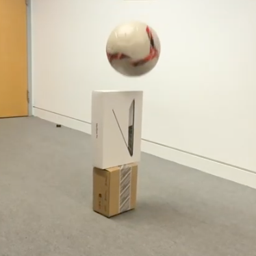

In [5]:
from PIL import Image


reference_frame = Image.open(
    "/users/gabrijel/projects/track-generator/physion2real/2.png"
).convert("RGB").resize((256, 256))
reference_frame

In [6]:
from transformers import AutoImageProcessor, AutoModel
from dino import extract_dino_features
import numpy as np

DINO_PATH = "/scratch/shared/beegfs/gabrijel/hf/models--facebook--dinov2-large/snapshots/47b73eefe95e8d44ec3623f8890bd894b6ea2d6c"

dino_processor = AutoImageProcessor.from_pretrained(
    DINO_PATH,
    do_resize=False,
    do_center_crop=False
)
dino = AutoModel.from_pretrained(DINO_PATH)
dino = dino.to(device)

In [7]:
frame_features = extract_dino_features(
    torch.from_numpy(np.array(reference_frame)),
    dino,
    dino_processor,
    device
)
frame_features = frame_features["last_hidden_state"]
frame_features.shape

torch.Size([1, 325, 1024])

In [8]:
from pathlib import Path

path = Path("./demos/physion/gravity4")
path.mkdir(exist_ok=True, parents=True)

In [9]:
from cotracker_utils import Visualizer

vis = Visualizer(
    save_dir=path,
    fps=60,
    linewidth=1,
    mode="rainbow"
)

In [10]:
reference_frame.save(path / "init_cond.jpg")

In [11]:
from train_raw_physion import sample_latte_raw
from einops import rearrange
from preprocessing import denormalize_points
from tqdm import tqdm
import numpy as np
from einops import rearrange
from PIL import Image


num_takes = 8

for take in tqdm(range(num_takes)):

    rollout_idx = len(
        [p for p in path.iterdir() if p.name.endswith(".mp4")]) + 1

    print(rollout_idx)

    pred_tracks = sample_latte_raw(
        model,
        frame_features[:, 1:, :],
        device,
        trajectory_stride=cfg.model.nn.trajectory_stride,
        method="euler",
        steps=10
    )  # [b, t, c, h, w]

    pred_tracks = rearrange(pred_tracks, "b t d h w -> b t h w d")
    pred_tracks = denormalize_points(pred_tracks, 256, 256)
    print(pred_tracks.var(dim=[1]).mean())

    vis.visualize(
        video=torch.zeros((1, 30, 3, 256, 256)),
        tracks=rearrange(
            pred_tracks,
            "b t h w c -> b t (h w) c"
        ),
        filename=f"{rollout_idx:06d}_tab20_without_bg_black"
    )
    np.save(path / f"{rollout_idx:06d}_tracks.npy",
            pred_tracks[0, ...].detach().cpu().numpy())

    Image.fromarray(
        rearrange(
            vis.visualize(
                video=rearrange(
                    torch.from_numpy(np.array(reference_frame)),
                    "h w c -> () () c h w"
                ),
                tracks=rearrange(
                    pred_tracks,
                    "b t h w c -> b t (h w) c"
                ),
                save_video=False
            )[0, 0, ...],
            "c h w -> h w c"
        ).numpy()
    ).save(path / "init_frame_queries.jpg")

  0%|          | 0/8 [00:00<?, ?it/s]

1
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(16.6371, device='cuda:5')


 12%|█▎        | 1/8 [00:02<00:14,  2.12s/it]

2
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(20.3490, device='cuda:5')


 25%|██▌       | 2/8 [00:04<00:12,  2.01s/it]

3
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(13.5149, device='cuda:5')


 38%|███▊      | 3/8 [00:05<00:09,  1.95s/it]

4
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(20.8577, device='cuda:5')


 50%|█████     | 4/8 [00:07<00:07,  1.94s/it]

5
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(20.3271, device='cuda:5')


 62%|██████▎   | 5/8 [00:09<00:05,  1.91s/it]

6
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(19.7716, device='cuda:5')


 75%|███████▌  | 6/8 [00:11<00:03,  1.91s/it]

7
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(17.5063, device='cuda:5')


 88%|████████▊ | 7/8 [00:13<00:01,  1.91s/it]

8
sampling method=euler, steps=10, atol=1e-05, rtol=1e-05 ...
tensor(17.0509, device='cuda:5')


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]
